In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

Text(0,0.5,u'$y$')

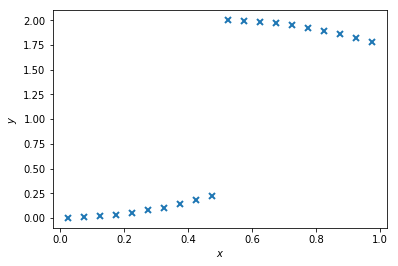

In [4]:
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]



#Xm = np.mean(X)
#Xv = np.std(X)
Xnorm = (X - 0.5) / 0.5

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [5]:
#build the model
k1 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale(Xnorm, Y, k1, nonstat)

In [6]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 1.],None,+ve
adaptive_lengthscale_gp.kern1.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.likelihood.variance,[ 1.],None,+ve
adaptive_lengthscale_gp.nonstat.signal_variance,[ 1.],None,+ve


In [7]:
m.kern1.lengthscales = 0.5
m.kern1.lengthscales.fixed = True
m.kern1.variance = .1
m.kern1.variance.fixed = True
#m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.likelihood.variance = 0.01
m.likelihood.variance.fixed = True

#m.nonstat.signal_variance = 2.
#m.nonstat.signal_variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)

In [8]:
m.optimize(maxiter=5000) # start near MAP

      fun: array([ 36.75274839])
 hess_inv: <41x41 LbfgsInvHessProduct with dtype=float64>
      jac: array([  7.69529209e-03,   2.01608983e-03,   1.65787435e-03,
         8.46403635e-04,   1.64906987e-03,  -6.81476803e-04,
        -3.92287695e-04,  -1.75840856e-05,   5.79118918e-05,
        -6.67785900e-05,   2.27795106e-05,  -1.12656625e-04,
        -1.10129446e-05,  -4.43289716e-05,   3.70627429e-05,
        -2.86468509e-05,   4.46273504e-06,  -1.43765821e-05,
         3.62662312e-05,   7.41695436e-05,   2.17287140e-02,
         1.05631115e-02,   4.31932021e-03,  -8.83536415e-03,
         4.08719878e-03,  -2.21095843e-03,  -3.82436893e-04,
        -2.05892842e-03,   2.50901500e-03,  -6.31889211e-04,
        -3.18180668e-05,   1.23878703e-02,   7.38755092e-04,
        -8.32349437e-05,  -2.37594344e-04,  -1.88922569e-03,
         7.05087882e-04,  -4.48762617e-04,   3.58460498e-03,
         2.35099842e-03,   3.08517304e-03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [9]:
m

Name,values,prior,constraint
adaptive_lengthscale_gp.V1,[[ -6.05010263e+00] [ -4.89434039e-01] [ 4.96458598e-01] [ 5.48782820e-01] [ 7.74950183e-03] [ 1.67689232e-02] [ -1.13013157e-02] [ 1.81303501e-02] [ 1.54956764e-02] [ -9.42602495e-03] [ 4.33190729e-03] [ -2.75994279e-02] [ -8.79929380e-04] [ 1.01875591e-04] [ 2.50279094e-03] [ 6.85726949e-03] [ 5.85078456e-04] [ 1.20418142e-03] [ 6.05787829e-03] [ 7.37679501e-03]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.V2,[[ 1.00967957] [-0.06357514] [ 0.79791017] [ 0.32719021] [ 0.31853488] [ 0.15701907] [-0.05847153] [ 0.13408424] [ 0.09446985] [ 0.14169001] [-0.0609029 ] [-1.25198473] [-0.16059048] [-0.2371595 ] [ 0.11891517] [-0.0180069 ] [ 0.09934236] [ 0.24920475] [ 1.29376939] [ 1.2508669 ]],"N([ 0.],[ 1.])",(none)
adaptive_lengthscale_gp.kern1.lengthscales,[ 0.5],None,[FIXED]
adaptive_lengthscale_gp.kern1.variance,[ 0.1],"Ga([ 1.],[ 1.])",[FIXED]
adaptive_lengthscale_gp.likelihood.variance,[ 0.01],None,[FIXED]
adaptive_lengthscale_gp.nonstat.signal_variance,[ 3.55151204],"Ga([ 1.],[ 1.])",+ve


In [10]:
samples = m.sample(200, verbose=True, epsilon=0.005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  99.0 %


In [11]:
xnew = np.linspace(0,1,50)[:,None]
xx = (xnew - 0.5)/0.5

In [12]:
sample_df = m.get_samples_df(samples)

In [13]:
sample_df

,adaptive_lengthscale_gp.V1,adaptive_lengthscale_gp.V2,adaptive_lengthscale_gp.kern1.lengthscales,adaptive_lengthscale_gp.kern1.variance,adaptive_lengthscale_gp.likelihood.variance,adaptive_lengthscale_gp.nonstat.signal_variance
0,"[[-3.61245207557], [-3.35975098128], [1.201024...","[[1.0128736581], [-0.177199300616], [0.6287732...",[0.5],[0.1],[0.01],[3.09312215796]
1,"[[-3.6444088073], [-3.43832260087], [1.2240886...","[[0.943725866886], [-0.120190831557], [0.71345...",[0.5],[0.1],[0.01],[3.11054944889]
2,"[[-4.32497586192], [-2.75846386235], [0.582501...","[[1.05025076861], [-0.106844447532], [0.719462...",[0.5],[0.1],[0.01],[2.98847109992]
3,"[[-4.85666586611], [-2.39316533437], [-0.19904...","[[1.10542169302], [-0.137366875581], [0.776453...",[0.5],[0.1],[0.01],[3.22467995747]
4,"[[-4.68793555596], [-2.30560068764], [-0.82366...","[[1.01316854022], [-0.158559303451], [0.907879...",[0.5],[0.1],[0.01],[2.89150221721]
5,"[[-4.54611541907], [-2.34528712282], [-0.75303...","[[1.01346725243], [-0.247170547673], [0.930503...",[0.5],[0.1],[0.01],[2.85346577647]
6,"[[-4.42507259529], [-2.66995563004], [-0.99225...","[[1.30874597464], [-0.211955402025], [0.999436...",[0.5],[0.1],[0.01],[2.0812240975]
7,"[[-4.21830690939], [-1.89551789717], [-0.85064...","[[1.23386843535], [-0.243038668244], [1.099002...",[0.5],[0.1],[0.01],[1.87668377878]
8,"[[-4.4113738066], [-1.26040030194], [-0.398142...","[[1.09489863661], [-0.24535045807], [0.9833644...",[0.5],[0.1],[0.01],[2.29446830817]
9,"[[-3.993669968], [-0.507257251048], [-1.126747...","[[0.890463099276], [-0.322170338573], [0.83087...",[0.5],[0.1],[0.01],[3.31244225404]


In [14]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [15]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [16]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [17]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [18]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:,0]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)

sig_samples = m.nonstat.signal_variance.get_samples_df(samples)
noise_samples = m.likelihood.variance.get_samples_df(samples)
signal_var = np.array([])
noise_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

for n in noise_samples:
    noise_var = np.append(noise_var, n)
    

In [19]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Std_noise = np.sqrt(noise_var)
    signal_std = np.sqrt(signal_var)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    lower1 = lower - 2*Std_noise
    upper1 = upper + 2*Std_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [20]:
X_true = np.linspace(0,1,100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]

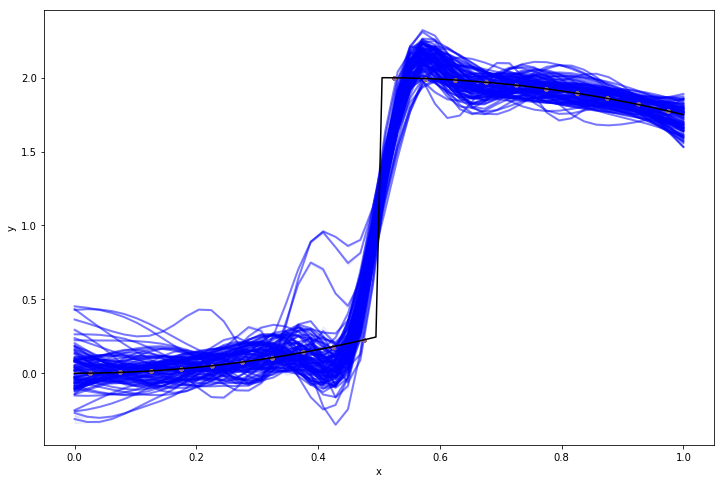

In [21]:
mini = 105
maxi = 200
plt.figure(figsize=(12,8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var[i])  
plt.plot(X_true, Y_true, 'k')

In [22]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

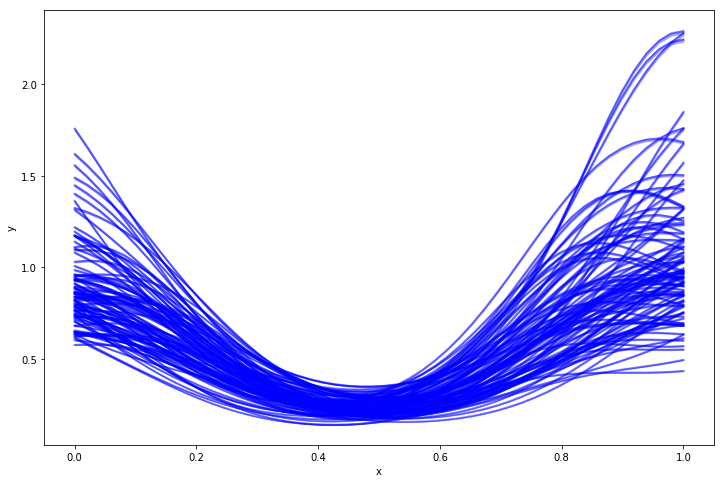

In [23]:
mini = 100
maxi = 200
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [26]:
m.predict_f_samples(xx, 100).shape

(100, 50, 1)